In [1]:
import pandas as pd
from pathlib import Path
import yfinance as yf
import numpy as np
import csv
import matplotlib.pyplot as plt
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

In [2]:
df_50 = pd.read_csv(
    Path("./Data/QM_50_03-09.csv")
)

In [3]:
tickers = list(df_50["Tickers"])
len(tickers)

50

In [4]:
weighting = 1/50

In [5]:
train_start = "2020-03"
train_end = "2020-09"

In [7]:
test_start = "2020-11"
test_end = "2021-01"

In [8]:
spy = np.array(yf.Ticker("spy").history(period="2y").loc[test_start:test_end]["Close"].pct_change().cumsum().apply(np.exp))

# Lagged Price Machine Learning Model

In [10]:
lags = 5

strat = np.zeros(61)

actual = np.zeros(61)

for ticker in tickers:
    # Pull the historical data
    df_price = yf.Ticker(ticker).history(period="max")
    df_price["return"] = df_price["Close"].pct_change()
    
    # Create lags price
    cols = []
    for lag in range(1, lags + 1):
        col = f'lag_{lag}'
        df_price[col] = df_price['Close'].shift(lag)
        cols.append(col)
        
    df_price.dropna(inplace=True)
    
    # Create train and test data
    df_price_train = df_price.loc[:train_end]
    
    df_price_test = df_price.loc[test_start:test_end]
    
    model = LogisticRegression(C=1e-2, solver="lbfgs",
                              multi_class="auto",
                              max_iter=1000)
    
    model.fit(df_price_train[cols], np.sign(df_price_train["return"]))
    
    df_price_test["prediction"] = model.predict(df_price_test[cols])
    
    df_price_test["strategy"] = df_price_test["prediction"] * df_price_test["return"]
    
    cum_ret = df_price_test[["strategy","return"]].cumsum().apply(np.exp)
    
    strat = strat + np.array(cum_ret["strategy"]) * weighting
    
    actual = actual + np.array(cum_ret["return"]) * weighting
    
    print(ticker)

CDNS
CARR
PKI
WHR
PWR
IDXX
AMZN
ALB
NVDA
NWS
LOW
SNPS
CRM
ADBE
CPRT
FDX
EBAY
DHR
AAPL
PYPL
SWK
AVGO
POOL
CZR
SWKS
TSLA
BBY
PNR
NWSA
GNRC
FB
ABMD
TRMB
CHRW
GLW
TMO
TEL
PENN
URI
ENPH
CTAS
FBHS
HOLX
FCX
CMG
TWTR
MPWR
WY
PHM
MAS


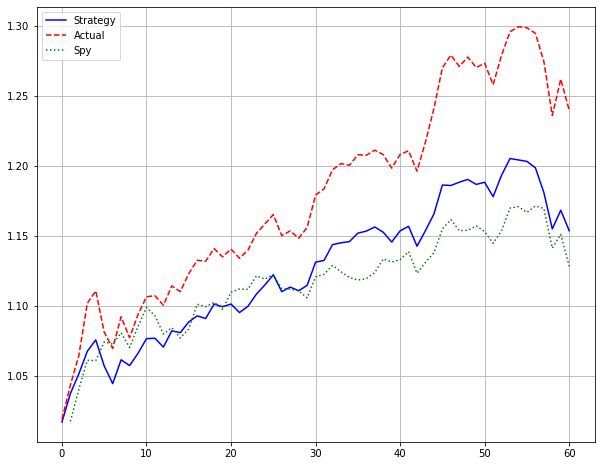

In [11]:
plt.figure(figsize=(10,8))
plt.plot(strat,'b-', label="Strategy")
plt.plot(actual,'r--', label="Actual")
plt.plot(spy,'g:', label="Spy")
plt.grid()
plt.legend()

# SMA Machine Learning Model

In [13]:
%%time
short_win = 5
long_win = 15

weighting = 1/50

strat = np.zeros(61)

actual = np.zeros(61)

for ticker in tickers:
    
    historical = yf.Ticker(ticker).history(period="max")
    historical["return"] = historical["Close"].pct_change()
    historical["SMA_short"] = historical["Close"].rolling(window=short_win).mean().shift()
    historical["SMA_long"] = historical["Close"].rolling(window=long_win).mean().shift()
    historical["distance1"] = (historical["Close"] - historical["SMA_short"]).shift()
    historical["distance2"] = (historical["SMA_short"] - historical["SMA_long"]).shift()
    historical["distance3"] = (historical["Close"] - historical["SMA_long"]).shift()
    
    historical.dropna(inplace=True)
    
    historical_train = historical.loc[train_start:train_end].copy()
    historical_test = historical.loc[test_start:test_end].copy()
    
    scaler = StandardScaler()
    X_scaler = scaler.fit(historical_train[["SMA_short","SMA_long","distance1","distance2","distance3"]])
    X_train_scaled = X_scaler.transform(historical_train[["SMA_short","SMA_long","distance1","distance2","distance3"]])
    X_test_scaled = X_scaler.transform(historical_test[["SMA_short","SMA_long","distance1","distance2","distance3"]])
    
    svm_model = SVC()
    svm_model = svm_model.fit(X_train_scaled, np.sign(historical_train[["return"]]))
    
    historical_test["prediction"] = svm_model.predict(X_test_scaled)
    
    historical_test["strategy"] = historical_test["prediction"] * historical_test["return"]
    
    cum_ret = historical_test[["strategy","return"]].cumsum().apply(np.exp)
    
    strat = strat + np.array(cum_ret["strategy"]) * weighting
    
    actual = actual + np.array(cum_ret["return"]) * weighting
    
    print(ticker)

CDNS
CARR
PKI
WHR
PWR
IDXX
AMZN
ALB
NVDA
NWS
LOW
SNPS
CRM
ADBE
CPRT
FDX
EBAY
DHR
AAPL
PYPL
SWK
AVGO
POOL
CZR
SWKS
TSLA
BBY
PNR
NWSA
GNRC
FB
ABMD
TRMB
CHRW
GLW
TMO
TEL
PENN
URI
ENPH
CTAS
FBHS
HOLX
FCX
CMG
TWTR
MPWR
WY
PHM
MAS
CPU times: user 5.99 s, sys: 396 ms, total: 6.39 s
Wall time: 1min 15s


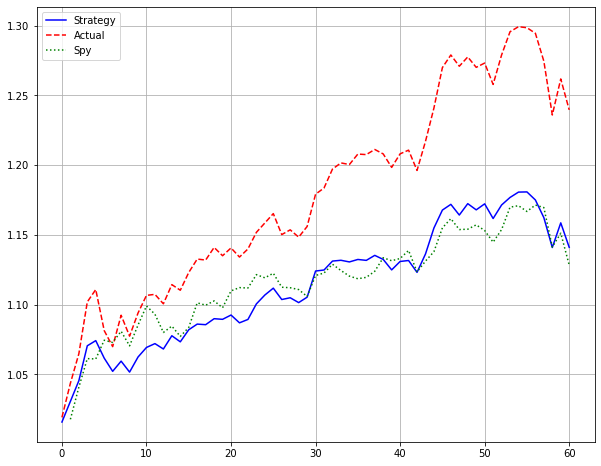

In [14]:
plt.figure(figsize=(10,8))
plt.plot(strat,'b-', label="Strategy")
plt.plot(actual,'r--', label="Actual")
plt.plot(spy,'g:', label="Spy")
plt.grid()
plt.legend()

# EMA Machine Learning Model

In [16]:
short_win = 12
long_win = 26

strat = np.zeros(61)

actual = np.zeros(61)

for ticker in tickers:
    historical = yf.Ticker(ticker).history(period="2y")
    historical["return"] = historical["Close"].pct_change()
    historical["exp1"] = historical["Close"].ewm(span=short_win, adjust=False).mean().shift()
    historical["exp2"] = historical["Close"].ewm(span=long_win, adjust=False).mean().shift()
    historical["distance1"] = (historical["Close"] - historical["exp1"]).shift()
    historical["distance2"] = (historical["Close"] - historical["exp2"]).shift()
    historical["distance3"] = (historical["exp1"] - historical["exp2"]).shift()
    historical.dropna(inplace=True)
    
    historical_train = historical.loc[train_start:train_end].copy()
    historical_test = historical.loc[test_start:test_end].copy()
    
    scaler = StandardScaler()
    X_scaler = scaler.fit(historical_train[["exp1","exp2","distance1","distance2","distance3"]])
    X_train_scaled = X_scaler.transform(historical_train[["exp1","exp2","distance1","distance2","distance3"]])
    X_test_scaled = X_scaler.transform(historical_test[["exp1","exp2","distance1","distance2","distance3"]])
    
    svm_model = SVC(C=0.5)
    svm_model = svm_model.fit(X_train_scaled, np.sign(historical_train[["return"]]))
    
    historical_test["prediction"] = svm_model.predict(X_test_scaled)
    
    historical_test["strategy"] = historical_test["prediction"] * historical_test["return"]
    
    cum_ret = historical_test[["strategy","return"]].cumsum().apply(np.exp)
    
    strat = strat + np.array(cum_ret["strategy"]) * weighting
    
    actual = actual + np.array(cum_ret["return"]) * weighting
    
    print(ticker)

CDNS
CARR
PKI
WHR
PWR
IDXX
AMZN
ALB
NVDA
NWS
LOW
SNPS
CRM
ADBE
CPRT
FDX
EBAY
DHR
AAPL
PYPL
SWK
AVGO
POOL
CZR
SWKS
TSLA
BBY
PNR
NWSA
GNRC
FB
ABMD
TRMB
CHRW
GLW
TMO
TEL
PENN
URI
ENPH
CTAS
FBHS
HOLX
FCX
CMG
TWTR
MPWR
WY
PHM
MAS


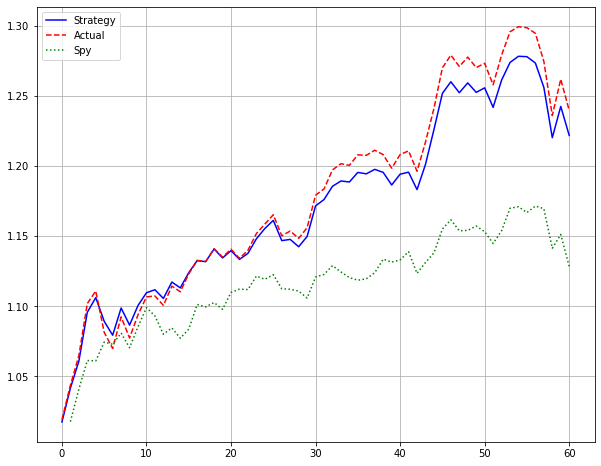

In [17]:
plt.figure(figsize=(10,8))
plt.plot(strat,'b-', label="Strategy")
plt.plot(actual,'r--', label="Actual")
plt.plot(spy,'g:', label="Spy")
plt.grid()
plt.legend()

# MACD Machine Learning Model

In [25]:
short_win = 12
long_win = 26
signal_line = 9
strat = np.zeros(61)

actual = np.zeros(61)

for ticker in tickers:
    historical = yf.Ticker(ticker).history(period="2y")
    historical["return"] = historical["Close"].pct_change()
    historical["exp1"] = historical["Close"].ewm(span=short_win, adjust=False).mean().shift()
    historical["exp2"] = historical["Close"].ewm(span=long_win, adjust=False).mean().shift()
    historical["macd"] = historical["exp1"] - historical["exp2"]
    historical["exp3"] = historical["Close"].ewm(span=signal_line, adjust=False).mean().shift()
    historical["macd_histogram"] = historical["macd"] - historical["exp3"]
    historical["lag_1"] = historical["Close"].shift()
    historical["roc"] = ((historical["Close"] - historical["lag_1"])/ historical["lag_1"]).shift()
    historical["macd_histogram_lag1"] = historical["macd_histogram"].shift()
    historical["roc_macd"] = ((historical["macd_histogram"]-historical["macd_histogram_lag1"])/historical["macd_histogram_lag1"])
    historical.dropna(inplace=True)
    
    historical_train = historical.loc[:train_end].copy()
    historical_test = historical.loc[test_start:test_end].copy()
    
    scaler = StandardScaler()
    X_scaler = scaler.fit(historical_train[["roc","roc_macd"]])
    X_train_scaled = X_scaler.transform(historical_train[["roc","roc_macd"]])
    X_test_scaled = X_scaler.transform(historical_test[["roc","roc_macd"]])
    
    svm_model = SVC(C=0.5)
    svm_model = svm_model.fit(X_train_scaled, np.sign(historical_train[["return"]]))
    
    historical_test["prediction"] = svm_model.predict(X_test_scaled)
    
    historical_test["strategy"] = historical_test["prediction"] * historical_test["return"]
    
    cum_ret = historical_test[["strategy","return"]].cumsum().apply(np.exp)
    
    strat = strat + np.array(cum_ret["strategy"]) * weighting
    
    actual = actual + np.array(cum_ret["return"]) * weighting
    
    print(ticker, accuracy_score(historical_test["prediction"],
                                np.sign(historical_test["return"])))

CDNS 0.5737704918032787
CARR 0.4262295081967213
PKI 0.5737704918032787
WHR 0.5573770491803278
PWR 0.5737704918032787
IDXX 0.6065573770491803
AMZN 0.4918032786885246
ALB 0.5245901639344263
NVDA 0.5573770491803278
NWS 0.4918032786885246
LOW 0.5737704918032787
SNPS 0.47540983606557374
CRM 0.5409836065573771
ADBE 0.5573770491803278
CPRT 0.5245901639344263
FDX 0.47540983606557374
EBAY 0.5245901639344263
DHR 0.5409836065573771
AAPL 0.5245901639344263
PYPL 0.5737704918032787
SWK 0.47540983606557374
AVGO 0.6229508196721312
POOL 0.5573770491803278
CZR 0.5901639344262295
SWKS 0.6229508196721312
TSLA 0.6229508196721312
BBY 0.5901639344262295
PNR 0.5245901639344263
NWSA 0.5901639344262295
GNRC 0.4918032786885246
FB 0.47540983606557374
ABMD 0.6065573770491803
TRMB 0.6721311475409836
CHRW 0.5409836065573771
GLW 0.5245901639344263
TMO 0.5737704918032787
TEL 0.6229508196721312
PENN 0.5737704918032787
URI 0.5245901639344263
ENPH 0.5901639344262295
CTAS 0.5409836065573771
FBHS 0.5081967213114754
HOLX 0.

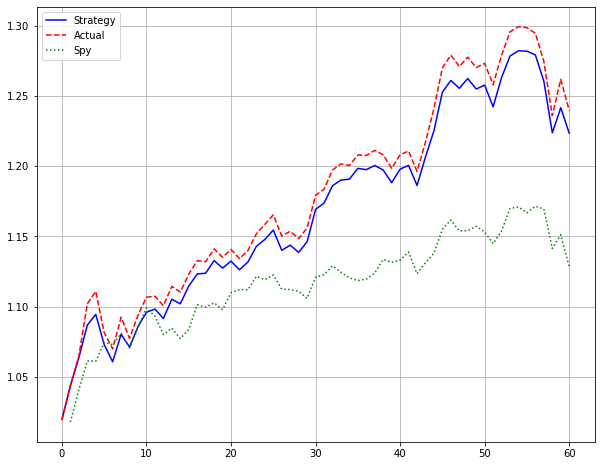

In [26]:
plt.figure(figsize=(10,8))
plt.plot(strat,'b-', label="Strategy")
plt.plot(actual,'r--', label="Actual")
plt.plot(spy,'g:', label="Spy")
plt.grid()
plt.legend()